# Test dino
use ipynb to speed up the base line work


In [1]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


IndexError: index 2 is out of bounds for axis 0 with size 2

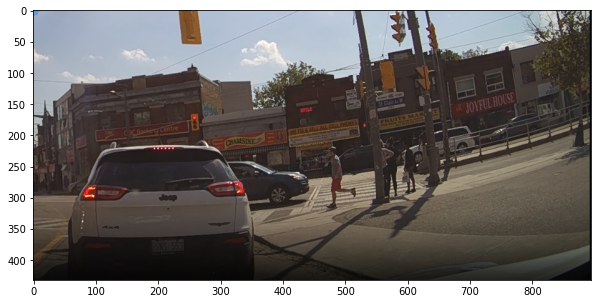

In [6]:
import os
import cv2
import torch
import torchvision

import warnings
import numpy as np
from PIL import Image
from glob import glob

import termcolor
import matplotlib.pyplot as plt

from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor
#TODO name!
from groundingdino.util.inference import load_model, load_image, predict, annotate

warnings.filterwarnings('ignore')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Paths to GroundingDINO and SAM checkpoints
GROUNDING_DINO_CONFIG_PATH = "/root/autodl-tmp/DINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = "/root/autodl-tmp/DINO/weights/groundingdino_swint_ogc.pth"
model_type = "default"
SAM_CHECKPOINT_PATH = "/root/autodl-tmp/sam_vit_h_4b8939.pth"

# Predict classes and hyper-param for GroundingDINO
BOX_THRESHOLD = 0.25
TEXT_THRESHOLD = 0.25
NMS_THRESHOLD = 0.8

# Initialize GroundingDINO model
grounding_dino_model = Model(
    model_config_path=GROUNDING_DINO_CONFIG_PATH, 
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH, 
    device=DEVICE
)

# Initialize SAM model and predictor
sam = sam_model_registry[model_type](checkpoint=SAM_CHECKPOINT_PATH)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

# Classes of interest (add as needed)
CLASSES = ['person', 'sidewalk']

output_dir = 'DINOmasked'
os.makedirs(output_dir, exist_ok=True)

def display_mask(mask, image_path,image):
    # Create a new subplot
    output_path = os.path.join(output_dir, image_path)
    plt.figure(figsize=(16,9))


    # Display the original image
    plt.imshow(image)
    plt.axis('off')

    # Display the mask
    # plt.imshow(mask, cmap='gray')
    show_anns(mask)
    # Display the plot
    plt.savefig(output_path)
    plt.close()

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))





# Prompting SAM with ROI
def segment_ROI(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray):
    sam_predictor.set_image(image)

    for input_box in xyxy:
        masks, _, _ = sam_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False,
        )

    return masks

def detect_road(image_path):
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    image_source, image2 = load_image(image_path)

    TEXT_PROMPT = "road . sidewalk"
    
    boxes, logits, phrases = predict(
        model= load_model(GROUNDING_DINO_CONFIG_PATH,GROUNDING_DINO_CHECKPOINT_PATH),
        image=image2,
        caption=TEXT_PROMPT,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD
    )
    '''
    tensor([[0.5001, 0.7093, 0.9966, 0.5736],
        [0.6953, 0.7150, 0.6069, 0.5601]]) tensor([0.4762, 0.3793]) ['road', 'sidewalk']
    
    '''

    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    cv2.imwrite("annotated_image.jpg", annotated_frame)

    DINO_boxes = np.array(boxes)

    SAM_masks = segment_ROI(
        sam_predictor=sam_predictor,
        image= image,
        xyxy= DINO_boxes,
    )

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(SAM_masks[0], plt.gca())
    show_box(DINO_boxes, plt.gca())
    plt.axis('off')
    plt.show()

    # display_mask(mask, image_path,image)

    return boxes, logits, phrases

boxes, logits, phrases = detect_road("input/scene_2.png")
print(boxes,logits,phrases)



In [5]:
def detect_road(image_path):
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # detect objects
    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes=CLASSES,
        box_threshold=BOX_THRESHOLD,
        text_threshold=BOX_THRESHOLD
    )
    detections.mask=  segment_ROI(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )

    # display_mask(detections.mask,image_path,image)
    
    return detections
det = detect_road("input/scene_2.png")


In [10]:
det.xyxy[0]

array([468.01025, 218.76471, 518.53186, 318.03473], dtype=float32)

Start =====
Processing:  0


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

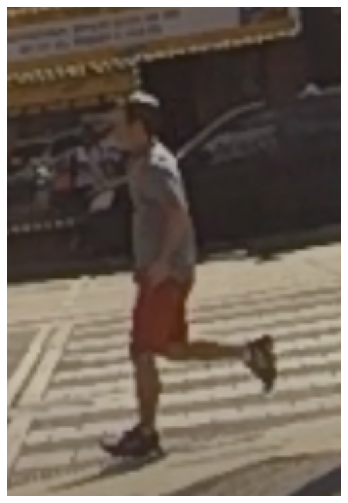

In [4]:
image_dir = "input"
    
print("Start =====")
i = 0
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
        image_path = os.path.join(image_dir, filename)
        output_path = os.path.join(output_dir, filename)
        if not os.path.exists(output_path):
            print("Processing: ", i)
            i += 1
            print(f"Image path: {termcolor.colored(os.path.basename(image_path), 'green')}")

            result = detect_road(image_path)
            
            print(f"Detected: {termcolor.colored(result, 'blue')}")